# 심층 합성곱 생성적 적대 신경망 (Deep Convolutional Generative Adversarial Networks, DCGAN)

## 생성적 적대 신경망(GANs) 

- [생성적 적대 신경망](https://arxiv.org/abs/1406.2661) (Generative Adversarial Networks, GANs)은 요즘 컴퓨터 과학에서 가장 흥미로운 아이디어 중 하나  
- 두개의 모델이 적대적인 과정을 통해 동시에 훈련  
- *생성자* ("예술가")는 진짜처럼 보이는 이미지를 생성하도록 배우는 와중에, *감별자* ("예술비평가")는 가짜의 이미지로부터 진짜를 구별하게 되는 것을 배우게 됨

![생성자와 감별자를 그린 도표](https://tensorflow.org/tutorials/generative/images/gan1.png)



- 훈련과정 동안 *생성자*는 점차 실제같은 이미지를 더 잘 생성  
- *감별자*는 점차 진짜와 가짜를 더 잘 구별  
- 이 과정은 *감별자*가 가짜 이미지에서 진짜 이미지를 더이상 구별하지 못하게 될때, 평형상태에 도달

![생성자와 감별자를 그린 두번째 도표](https://tensorflow.org/tutorials/generative/images/gan2.png)

- 이 과정을 MNIST 데이터를 이용하여 구현  
- 아래의 애니메이션은 50 에포크(epoch)동안 훈련한 *생성자*가 생성해낸 연속된 이미지들을 보여줌  
- 이미지들은 랜덤한 잡음으로 부터 시작되었고, 점차 시간이 지남에 따라 손으로 쓴 숫자들을 닮아가게 됨

![출력 예시](https://tensorflow.org/images/gan/dcgan.gif)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, BatchNormalization,\
                                                    Dropout, Flatten, Reshape, LeakyReLU
import time
from IPython import display

### 데이터셋 로딩 및 준비
- 생성자와 감별자를 훈련하기위해 MNIST 데이터셋을 사용  
- 생성자는 손글씨 숫자 데이터를 닮은 숫자들을 생성할 것임

In [2]:
# mnist dataset load
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
#(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images.shape

(60000, 28, 28)

In [3]:
# 이미지에 dimension 더해주고 [-1, 1]로 정규화
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 

print(train_images.shape)
print(train_images.min(), train_images.max())

(60000, 28, 28, 1)
-1.0 1.0


In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [5]:
# 데이터 배치를 만들고 섞음
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE) \
                                        .batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

train_dataset

<PrefetchDataset element_spec=TensorSpec(shape=(256, 28, 28, 1), dtype=tf.float32, name=None)>

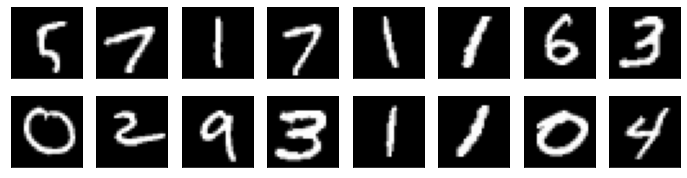

In [6]:
plt.figure(figsize=(12, 3))
for i in range(16):
    plt.subplot(2, 8, i+1)
    plt.imshow(train_images[100+i].reshape(28, 28), cmap = 'gray')
    plt.xticks([])
    plt.yticks([])

## 모델 만들기 

### 생성자

- 생성자는 시드값 (seed; 랜덤한 잡음)으로부터 CNN 의 역순으로 이미지를 생성하기 위해, `tf.keras.layers.Conv2DTranspose` (inverse Convolution 을 통한 upsampling) 층을 이용  
- stride=(2, 2) 일 경우 dimension 이 2 배로 upsampling 됨
- 처음 `Dense`층은 seed 값을 input으로 받음  
- 그 다음 원하는 사이즈 28x28x1의 이미지가 나오도록 Conv2DTranspose 를 이용한 upsampling을 여러번 함  
- tanh를 사용하는 마지막 층을 제외한 나머지 각 층마다 활성함수로 `tf.keras.layers.LeakyReLU`을 사용하고 있음을 주목할 것

<img src="https://github.com/ironmanciti/AI_Platform_ImageAnalysis/blob/main/GAN_Generator.PNG?raw=true" width="600">

- "same" padding and stride = 1, the output is the same size  
- "same" padding and stride = 2, the output is double the size 

In [7]:
generator = Sequential([
    Dense(7*7*256, use_bias=False, input_shape=(100,)),  # seed 를 입력으로 받음, 출력 12544
    BatchNormalization(),
    LeakyReLU(),
    Reshape((7, 7, 256)),
    Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2DTranspose(32, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, 
                                                                    activation='tanh')
])

assert generator.output_shape == (None, 28, 28, 1)

(아직 훈련이 되지않은) 생성자를 이용해 이미지를 생성

In [8]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

model(input, training=False)   
- False - inference. No Dropout and BatchNormalization 
- True - training  

(1, 28, 28, 1)


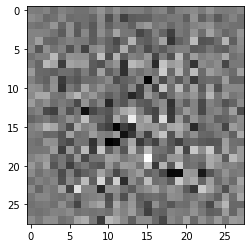

In [9]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### 감별자 
- 감별자는 합성곱 신경망(Convolutional Neural Network, CNN) 기반의 이미지 분류기
- MNIST dataset 은 input_shape (28, 28, 1)  
- sigmoid output 은 probability scalar 값  
- 일반 CNN 과의 차이 : pooling layer가 없고, stride 를 통하여 downsampling  

<img src="https://github.com/ironmanciti/AI_Platform_ImageAnalysis/blob/main/GAN_Discriminator.PNG?raw=true" width="700">

In [10]:
discriminator = Sequential([
    Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
    LeakyReLU(),
    Dropout(0.3),
    Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    LeakyReLU(),
    Dropout(0.3),
    Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
    LeakyReLU(),
    Dropout(0.3),
    Conv2D(512, (5, 5), strides=(2, 2), padding='same'),
    LeakyReLU(),
    Dropout(0.3),
    Flatten(),
    Dense(1)
])

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)        

- (아직까지 훈련이 되지 않은) 감별자를 사용하여, 생성된 이미지가 진짜인지 가짜인지 판별  
- 모델은 진짜 이미지에는 양수의 값 (positive values)을, 가짜 이미지에는 음수의 값 (negative values)을 출력하도록 훈련

In [11]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00072316]], shape=(1, 1), dtype=float32)


## 손실함수와 옵티마이저 정의
- 두 모델의 손실함수와 옵티마이저를 정의  
- Discriminator 의 output 이 sigmoid 이므로, binary crossentropy 를 loss function 으로 사용 
- from_logits=True 로 지정   


- tf.keras.losses.BinaryCrossentropy()(y_true, y_pred, sample_weight=None)

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### 감별자 손실함수 

- 감별자가 가짜 이미지에서 얼마나 진짜 이미지를 잘 판별하는지 수치화하는 함수  
- 진짜 이미지에 대한 감별자의 예측과 1로 이루어진 행렬을 비교하고, 가짜 (생성된) 이미지에 대한 감별자의 예측과 0으로 이루어진 행렬을 비교  
- shape 은 (256, 1) $\rightarrow$ BATCHSIZE
- real image 는 label [11111..111], fake image 는 label [00000....000] 이 ground truth  
- discriminator 는 real 은 real 로, fake 는 fake 로 바르게 판별해야 하므로 real_loss + fake_loss 가 minimize 되도록 training

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # [111,,,111] 과 real_output 차이
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)    # [000,,,,000] 과 fake_output 차이
    total_loss = real_loss + fake_loss
    return total_loss

### 생성자 손실함수

- 감별자를 얼마나 잘 속였는지에 대해 수치화  
- 직관적인 느낌으로, 생성자가 원활히 수행되고 있다면, 감별자는 가짜 이미지를 진짜 (또는 1)로 분류를 할 것임. 
- 여기서 우리는 생성된 이미지에 대한 감별자의 결정(fake_output)을 1로 이루어진 행렬과 비교를 할 것임 (감별자가 감별한 결과가 모두 1 이 되어야 생성자가 감별자를 완벽히 속인 것임)  


- fake_output = discriminator(generated_images, training=True)

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # [111,,111] 과 fake_output 차이

### 감별자와 생성자는 따로 훈련되기 때문에, 감별자와 생성자의 옵티마이저는 다르다.

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### 체크포인트 저장

- optimizer 와 model 저장 


-  tf.train.Checkpoint(optimizer=optimizer, model=model)

In [16]:
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 훈련 루프 정의

- 훈련 루프는 생성자가 입력으로 random seed를 받는 것으로부터 시작  
- 그 seed 값을 사용하여 이미지를 생성  
- 감별자를 사용하여 (훈련 세트에서 갖고온) 진짜 이미지와 (생성자가 생성해낸) 가짜 이미지를 분류  
- 각 모델의 손실을 계산하고, 그래디언트 (gradients)를 사용해 생성자와 감별자를 업데이트

### 생성자 Training
<img src="https://github.com/ironmanciti/AI_Platform_ImageAnalysis/blob/main/adverseModel.PNG?raw=true" width="500">

### 감별자 Training
<img src="https://github.com/ironmanciti/AI_Platform_ImageAnalysis/blob/main/GANtraining.PNG?raw=true" width="500">

In [17]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [18]:
# `tf.function` 데코레이터는 함수를 "컴파일"
# 두개 module 의 gradient 를 따로 tracking 함

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        generated_images = generator(noise, training=True)     # noise 에서 fake image 생성 

        real_output = discriminator(images, training=True)       # real image 에 대한 감별자의 output
        fake_output = discriminator(generated_images, training=True)  # fake image 에 대한 감별자의 output

        # fake image 에 대한 감별자의 output 을 all 1 로 만들기 위한 생성자 손실함수
        gen_loss = generator_loss(fake_output)  
        # real image 와 fake image 의 total loss 를 minimize 하기 위한 감별자 손실함수
        disc_loss = discriminator_loss(real_output, fake_output)  

    # 손실함수와 trainable parameter 지정
    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                                           generator.trainable_variables)  
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                            discriminator.trainable_variables)    

    # gradient update
    generator_optimizer.apply_gradients(zip(gradients_of_generator, 
                                                                generator.trainable_variables))   
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, 
                                                                discriminator.trainable_variables))

In [19]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # GIF를 위한 이미지를 바로 생성
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # 15 에포크가 지날 때마다 모델을 저장
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
        
    # 마지막 에포크가 끝난 후 생성
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

**이미지 생성 및 저장**

-`training`이 False로 맞춰진 것을 주목. 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행

In [20]:
def generate_and_save_images(model, epoch, test_input):
    
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## 모델 훈련
- 위에 정의된 `train()` 메서드를 생성자와 감별자를 동시에 훈련하기 위해 호출  
- 생성적 적대 신경망을 학습하는 것은 매우 까다로울 수 있dma. 생성자와 감별자가 서로를 제압하지 않는 것이 중요 (비슷한 속도로 train)
- 훈련 초반부에는 생성된 이미지는 랜덤한 노이즈처럼 보이나 훈련이 진행될수록, 생성된 숫자는 점차 진짜처럼 보임  
- 약 50 에포크가 지난 후, MNIST 숫자와 닮은 이미지가 생성  
- 코랩에서 기본 설정으로 실행하면, 에포크마다 1분정도 소요

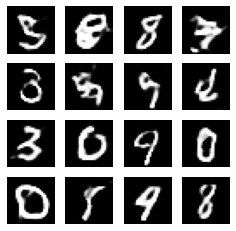

CPU times: user 4min 17s, sys: 30.9 s, total: 4min 48s
Wall time: 15min 19s


In [21]:
%%time
train(train_dataset, EPOCHS)

마지막 체크포인트를 복구합니다.

In [22]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## GIF 생성

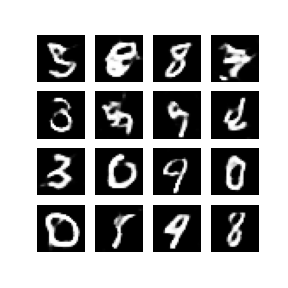

In [23]:
# 에포크 숫자를 사용하여 하나의 이미지를 보여준다
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)